<a href="https://colab.research.google.com/github/dokunoale/chagas/blob/fix%2Fnotebook/notebooks/chagas_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of Chagas Disease from the ECG

Questo progetto è ispirato dalla [George B. Moody PhysioNet Challenge 2025](https://moody-challenge.physionet.org/2025/).

La **malattia di Chagas** è una patologia parassitaria diffusa in America Centrale e Meridionale, che può causare gravi danni al sistema cardiovascolare. La diagnosi è spesso tardiva a causa di un lungo periodo asintomatico. I test sierologici, pur essendo specifici, sono costosi e disponibili in quantità limitate, il che ne impedisce l’uso come strumento di screening di massa. Tuttavia, i trattamenti farmacologici esistenti risultano tanto più efficaci quanto prima vengono somministrati, rendendo cruciale l’identificazione precoce dei soggetti a rischio.

L'obiettivo del progetto è sviluppare una rete neurale in grado di analizzare **elettrocardiogrammi** (ECG) - un esame non invasivo, economico e ampiamente diffuso - per effettuare una pre-selezione dei pazienti da sottoporre al test sierologico, ottimizzando così l’impiego delle risorse disponibili.

Il modello potrà inoltre fornire un supporto clinico segnalando precocemente l’insorgenza di eventuali complicanze, consentendo un intervento tempestivo nei casi in cui la terapia risulta più efficace.

L'esperimento è reperibile su [GitHub](https://github.com/dokunoale/chagas.git).



## Introduzione

L’obiettivo del nostro progetto è sviluppare un modello di classificazione binaria che, a partire dai dati ECG, sia in grado di predire la presenza della malattia di Chagas. Il modello dovrà fornire sia un'**etichetta binaria** (positivo/negativo) sia la **probabilità** associata alla presenza della malattia.

Ciascun campione è costituito da una sequenza ECG di 7 secondi, registrata a 400 Hz su 12 derivazioni, per una dimensione complessiva di (2800, 12). Il progetto prevede la sperimentazione di diversi modelli di deep learning specificamente progettati per l’analisi di segnali ECG, al fine di individuare l’architettura più adatta al nostro contesto applicativo.

In [1]:
!git clone -b dev https://github.com/dokunoale/chagas.git
!pip install -q -r chagas/requirements.txt

import sys
sys.path.append("/content/chagas/src")

Cloning into 'chagas'...
remote: Enumerating objects: 844, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 844 (delta 150), reused 110 (delta 71), pack-reused 565 (from 2)
Receiving objects: 100% (844/844), 19.83 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (424/424), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 22.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

## Dataset

I dati includono una parte del dataset [CODE-15%](https://zenodo.org/records/4916206) e il dataset [SaMi-Trop](https://zenodo.org/records/4905618), le etichette sulla malattia di Chagas sono fornite dalla piattaforma PhisioNet. Il dataset è bilanciato, con 5611 casi positivi e 5611 casi negativi.

- **CODE-15%** contiene oltre 300mila record di ECG raccolti in Brasile tra il 2010 e il 2016. Le etichette binarie di Chagas sono auto-riportate e pertanto potrebbero essere state validate o meno. Da questo dataset abbiamo estratto 3.980 campioni positivi e 5611 negativi.

- **Sami-Trop** contiene 1.631 registrazioni ECG a 12 derivazioni raccolte da pazienti affetti da malattia di Chagas in Brasile tra il 2011 e il 2012. e etichette di Chagas sono convalidate da test sierologici e sono tutte positive.



### Formato dei dati

I dati sono archiviati in file nel formato **WFDB**, composto da:

- un file di segnale in formato binario `.dat` che contiene i dati grezzi del segnale ECG
- un file d'intestazione `.hea`, che specifica informazioni quali la frequenza di campionamento, la durata del segnale, la risoluzione e i nomi dei canali ECG, nonché i valori iniziali e i checksum per ciascun canale. Include dati demografici e le etichette di Chagas, sotto forma di commento.

Ad esempio il seguente file, chiamato `14.hea`, associato al file `14.dat`, rappresenta un campione a 12 derivazioni, campionato a 400$Hz$ e composto da 4096 rilevazioni. Il paziente è una donna di 74 anni, presumibilmente negativa alla malattia di Chagas.
```text
14 12 400 4096
14.dat 16 1000(0)/mV 16 0 107 8680 0 I
14.dat 16 1000(0)/mV 16 0 1227 -1353 0 II
14.dat 16 1000(0)/mV 16 0 1120 -10000 0 III
14.dat 16 1000(0)/mV 16 0 -671 21850 0 AVR
14.dat 16 1000(0)/mV 16 0 -511 -31211 0 AVL
14.dat 16 1000(0)/mV 16 0 1174 -13411 0 AVF
14.dat 16 1000(0)/mV 16 0 -457 14574 0 V1
14.dat 16 1000(0)/mV 16 0 -1204 26357 0 V2
14.dat 16 1000(0)/mV 16 0 846 5156 0 V3
14.dat 16 1000(0)/mV 16 0 -389 28928 0 V4
14.dat 16 1000(0)/mV 16 0 389 -18825 0 V5
14.dat 16 1000(0)/mV 16 0 -1623 4933 0 V6
# Age: 74
# Sex: Female
# Chagas label: False
# Source: CODE-15%
```

### *Split* e caricamento del dataset

I dati sono stati suddivisi staticamente nei set di **addestramento**, **validazione** e **test**, preservando in ciascuno la distribuzione originale dei dati provenienti dai dataset CODE-15% e SaMi-Trop.

Il dataset è diviso come segue

- training set (70%): 3935 positivi, 3920 negativi

- validation set (10%): 557 positivi, 565 negativi

- test set (20%): 1119 positivi, 1126 negativi

In [3]:
# Download the dataset
import gdown
url = "https://drive.google.com/file/d/1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC/view?usp=drive_link"
gdown.download(url, "dataset.zip", quiet=False, fuzzy=True)
!unzip -q /content/dataset.zip -d chagas/data/

Downloading...
From (original): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC
From (redirected): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC&confirm=t&uuid=b25ccd50-e433-43fe-a51f-5fa682b826b6
To: /content/dataset.zip
100%|██████████| 623M/623M [00:11<00:00, 56.0MB/s]


Una classe custom `WfdbLoader` permette la conversione dei dati in formato WFDB in **numpy** array leggibili da **TensorFlow**. Contestualmente al caricamento dei dati, applica una prima normalizzazione, per avere tutti i dati all'interno dello stesso intervallo.

In [4]:
from preprocessing.tf_dataset_loader import WfdbLoader
data_path = "/content/chagas/data/big_splitted_dataset/"

# training set loading
train = WfdbLoader(label = 'Chagas label')
train.add_dataset(data_path + "train/positives")
train.add_dataset(data_path + "train/negatives")
X_train, y_train = train.load(shuffle=True, verbose=True)

# validation set loading
validation = WfdbLoader(label = 'Chagas label')
validation.add_dataset(data_path + "val/positives")
validation.add_dataset(data_path + "val/negatives")
X_val, y_val = validation.load(shuffle=True, verbose=True)

# test set loading
test = WfdbLoader(label = 'Chagas label')
test.add_dataset(data_path + "test/positives")
test.add_dataset(data_path + "test/negatives")
X_test, y_test = test.load(shuffle=True, verbose=True)

# Array of dictionaries with more info for model analysis
y_test_info = test.get_metadata()


Loading records: 100%|██████████| 2245/2245 [00:12<00:00, 174.01record/s]


## Preprocessing

In questo paragrafo esploreremo i segnali presenti nel dataset utilizzando un campione ridotto e un modello semplificato, con l’obiettivo di individuare eventuali criticità nei dati. Il layer dedicato alla generazione dello spettrogramma verrà descritto in dettaglio nel paragrafo successivo, dedicato all’architettura dei modelli.


In [ ]:
from preprocessing.filters import FiltfiltNoiseReducer
from preprocessing.tf_dataset_loader import WfdbLoader
from models.layers import LightLogSpectrogram
from models.utils import show_spectrogram_from_sample, show_raw_ecg_from_sample

def naive_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = LightLogSpectrogram()(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.models.Model(inputs, outputs)


data_path = "/content/chagas/data/big_splitted_dataset/"
examples, _ = WfdbLoader(label = 'Chagas label').add_dataset(data_path + "train/positives").load(verbose=True)
raw_sample = examples[3000]

Loading records: 100%|██████████| 3935/3935 [00:26<00:00, 151.32record/s]


Questi dati, rappresentando esempi realistici di segnali ECG del mondo reale, possono contenere artefatti sia visibili che difficilmente percettibili a occhio nudo.
Dall'analisi dei grafici emerge chiaramente la presenza significativa di rumore di fondo. Si osserva inoltre una marcata eterogeneità nella qualità del segnale, con alcuni lead che mostrano forme d'onda più nitide e regolari, mentre altri presentano tracciati più disturbati e irregolari. Questa variabilità è tipica delle registrazioni ECG cliniche reali, dove fattori come il posizionamento degli elettrodi, i movimenti del paziente e le interferenze ambientali possono influenzare significativamente la qualità della registrazione.

L'analisi dello **spettrogramma** rivela chiaramente la correlazione tra le caratteristiche del segnale grezzo e la loro rappresentazione nel dominio tempo-frequenza: gli ampi movimenti e le vibrazioni di bassa frequenza (artefatti da movimento del paziente, deriva della linea di base, interferenze respiratorie) si manifestano come bande ad alta intensità nella parte inferiore dello spettrogramma, mentre i disturbi ad alta frequenza - principalmente interferenze elettriche della rete di alimentazione, problemi di messa a terra e rumore elettronico - appaiono come linee orizzontali marcate nella parte superiore, risultando chiaramente identificabili nonostante la loro ampiezza relativamente piccola nel segnale temporale grazie alla loro natura quasi-stazionaria e frequenza caratteristica.

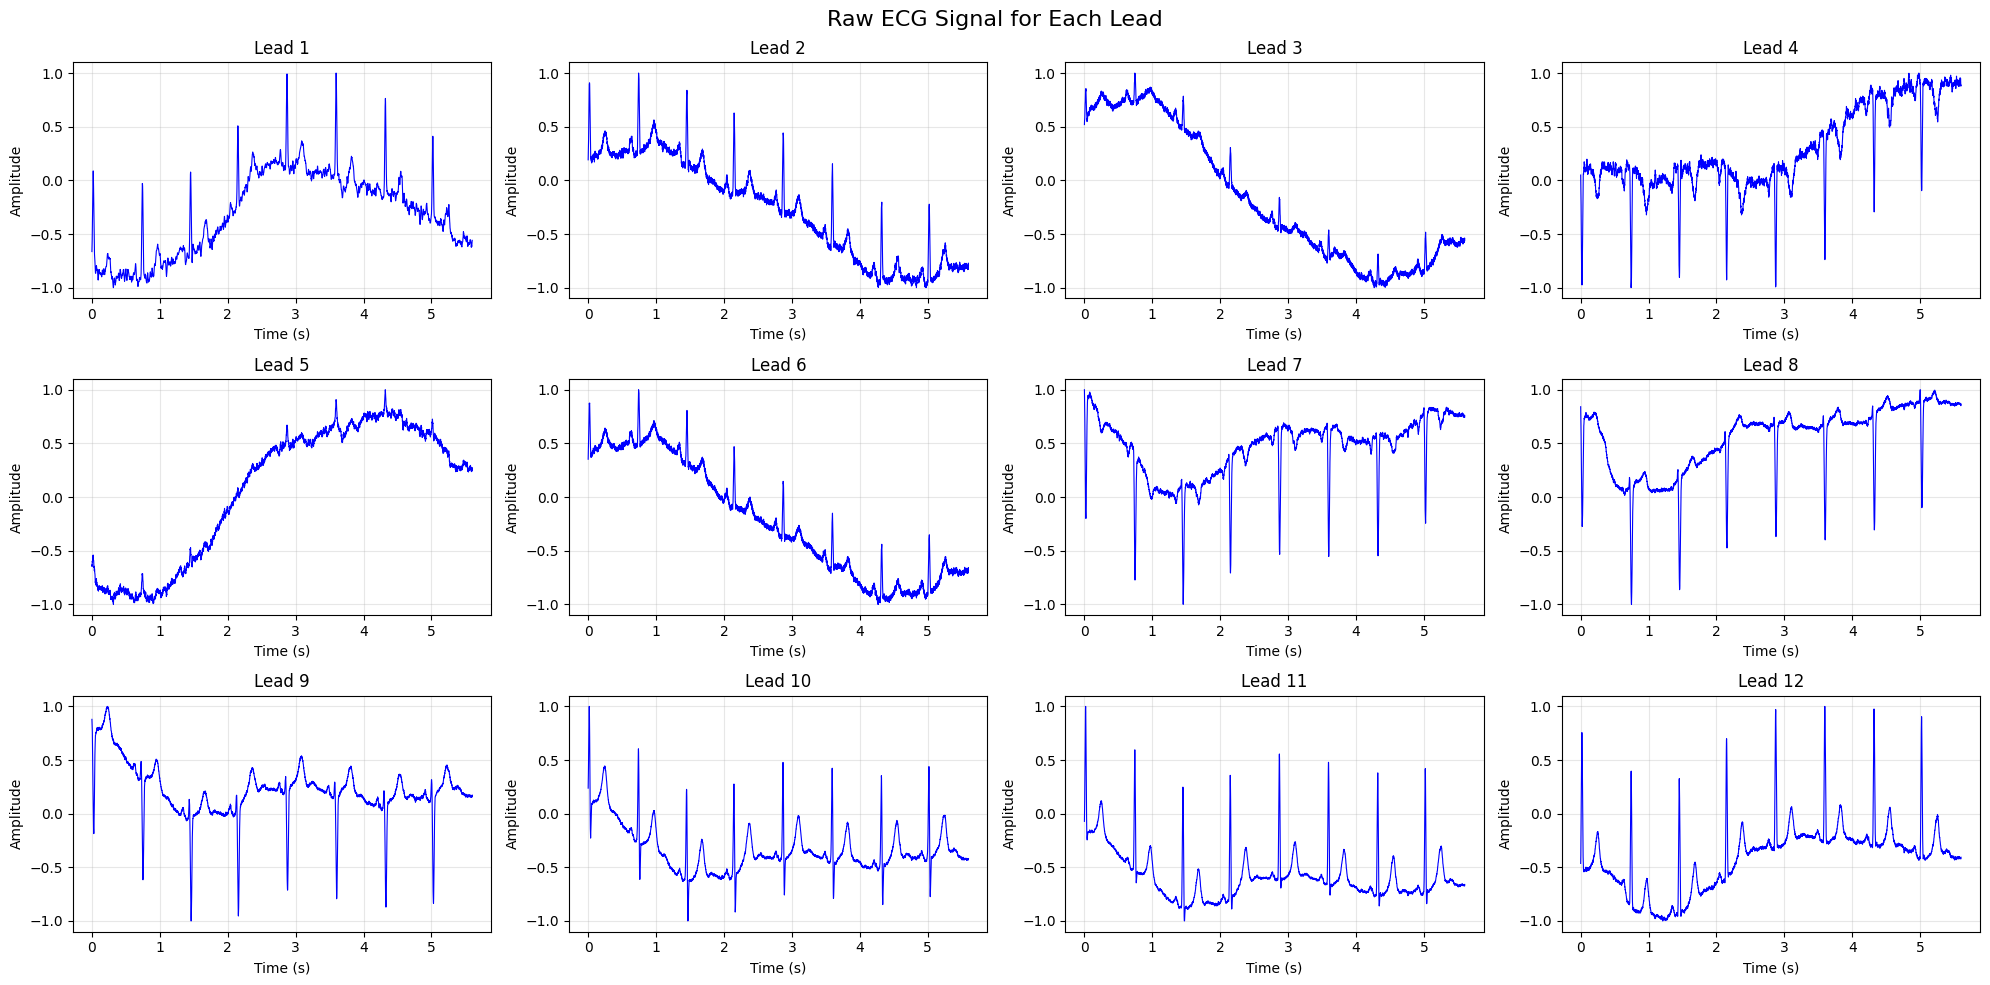

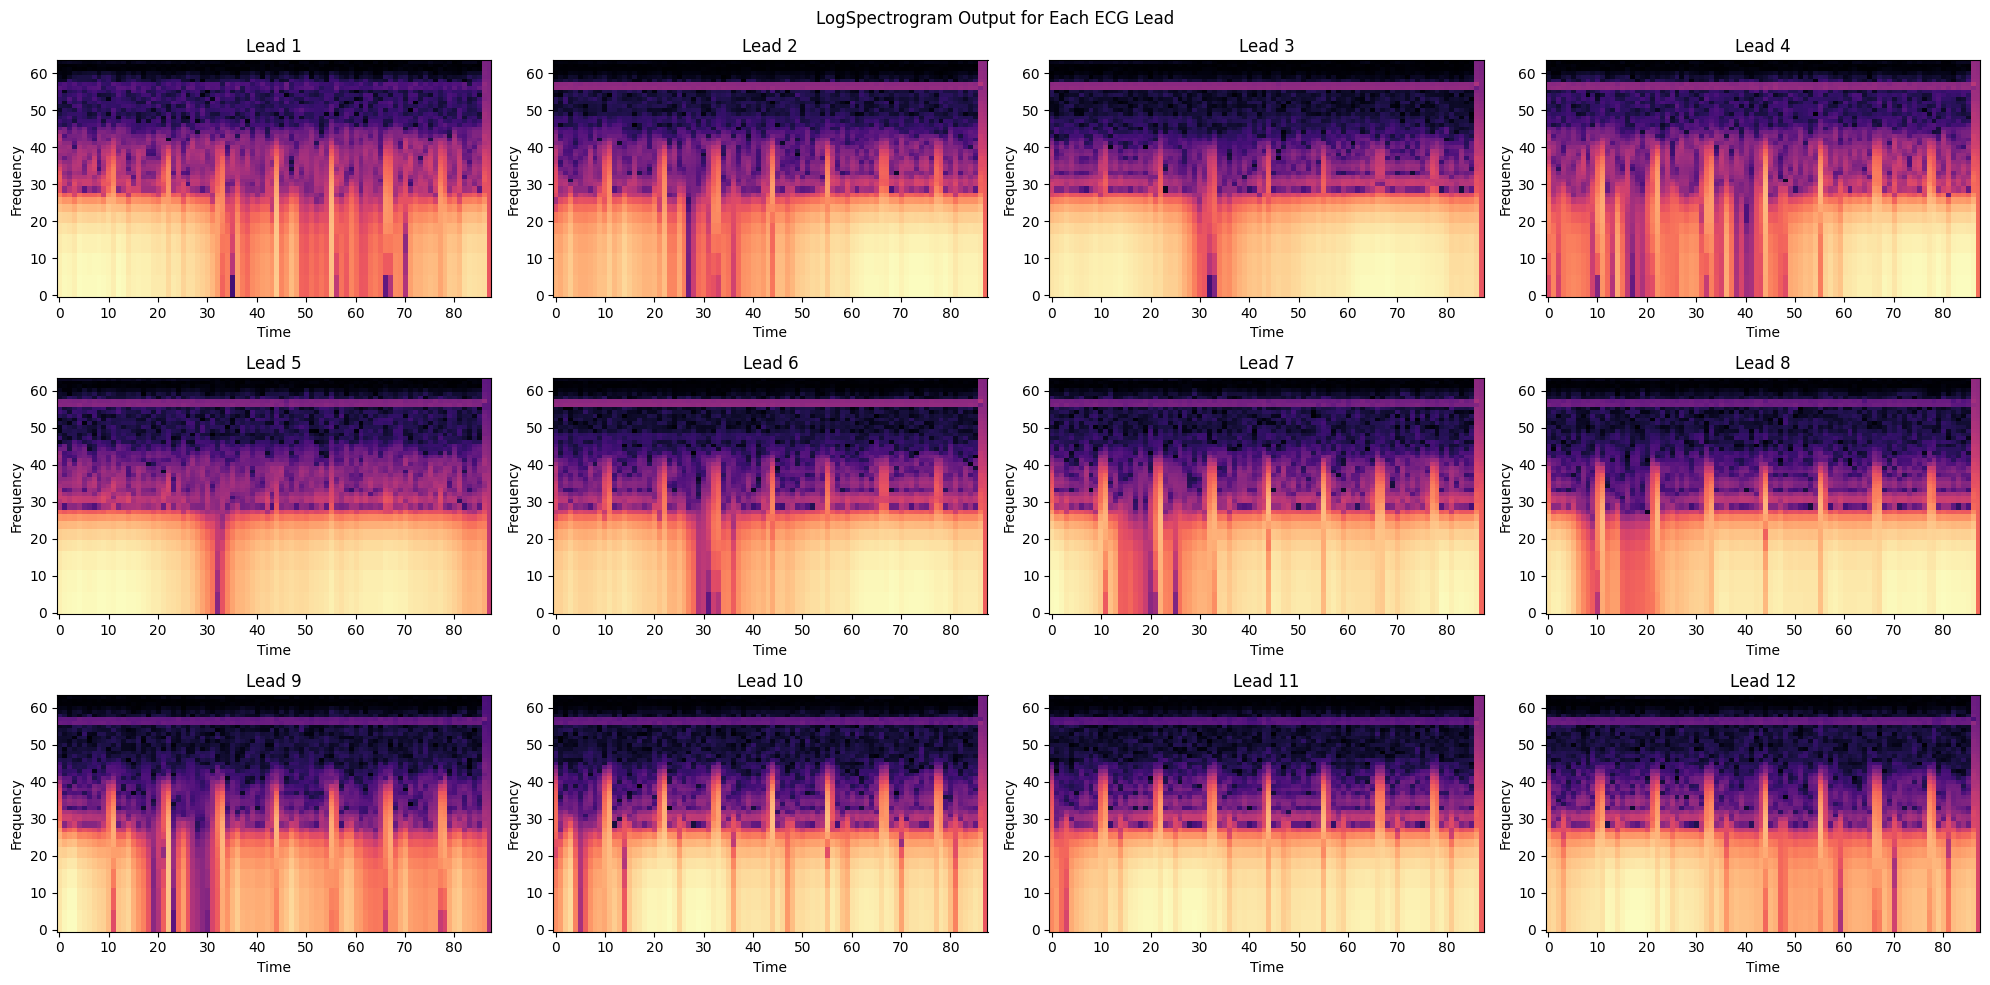

In [ ]:
show_raw_ecg_from_sample(raw_sample)
show_spectrogram_from_sample(naive_model((2800, 12)), raw_sample)

Risulta chiara la necessità di ripulire il segnale da queste interferenze. Il **denoiser** utilizzato è ispirato alla fase di preprocessing descritta nello studio [ECG biometric recognition: Permanence analysis of QRS signals for 24 hours continuous authentication](https://ieeexplore.ieee.org/abstract/document/6707790/authors#authors).

Abbiamo ricostruito l'architettura descritta nel paper nella classe custom `FiltfiltNoiseReducer`.

- **Filtro Notch** (IIR): Il filtro notch (di default a 60 Hz, frequenza della rete elettrica brasiliana) elimina le linee orizzontali marcate visibili nella parte superiore dello spettrogramma, corrispondenti alle interferenze elettriche della rete di alimentazione e ai disturbi di messa a terra.

- **Filtro High-pass Butterworth**: Il filtro high-pass rimuove le bande ad alta intensità nella parte inferiore dello spettrogramma, eliminando le componenti a bassa frequenza generate dai movimenti del paziente, dalla deriva della linea di base e dalle variazioni di contatto degli elettrodi che causano l'instabilità visibile nei segnali grezzi.

- **Filtro Low-pass** (opzionale): Il filtro low-pass (default 60 Hz) attenua le componenti ad alta frequenza residue come il rumore muscolare e le interferenze elettromagnetiche, che contribuiscono al rumore generale dei tracciati senza fornire informazioni clinicamente rilevanti per l'analisi ECG.

`FiltfiltNoiseReducer` applica i filtri attraverso la funzione `filtfilt` che implementa un **filtraggio a fase zero**, garantendo l'assenza di sfasamenti nel segnale filtrato e preservando la morfologia dei tracciati ECG con l'allineamento temporale preciso dei complessi QRS. La funzione filtra il segnale prima in avanti e poi all'indietro: questo doppio passaggio cancella le distorsioni di fase introdotte dal filtro, eliminando ritardi temporali che potrebbero compromettere l'analisi clinica e mantenendo il segnale temporalmente fedele all'originale.

Filtering records - filtfilt: 100%|██████████| 1/1 [00:00<00:00, 91.09record/s]


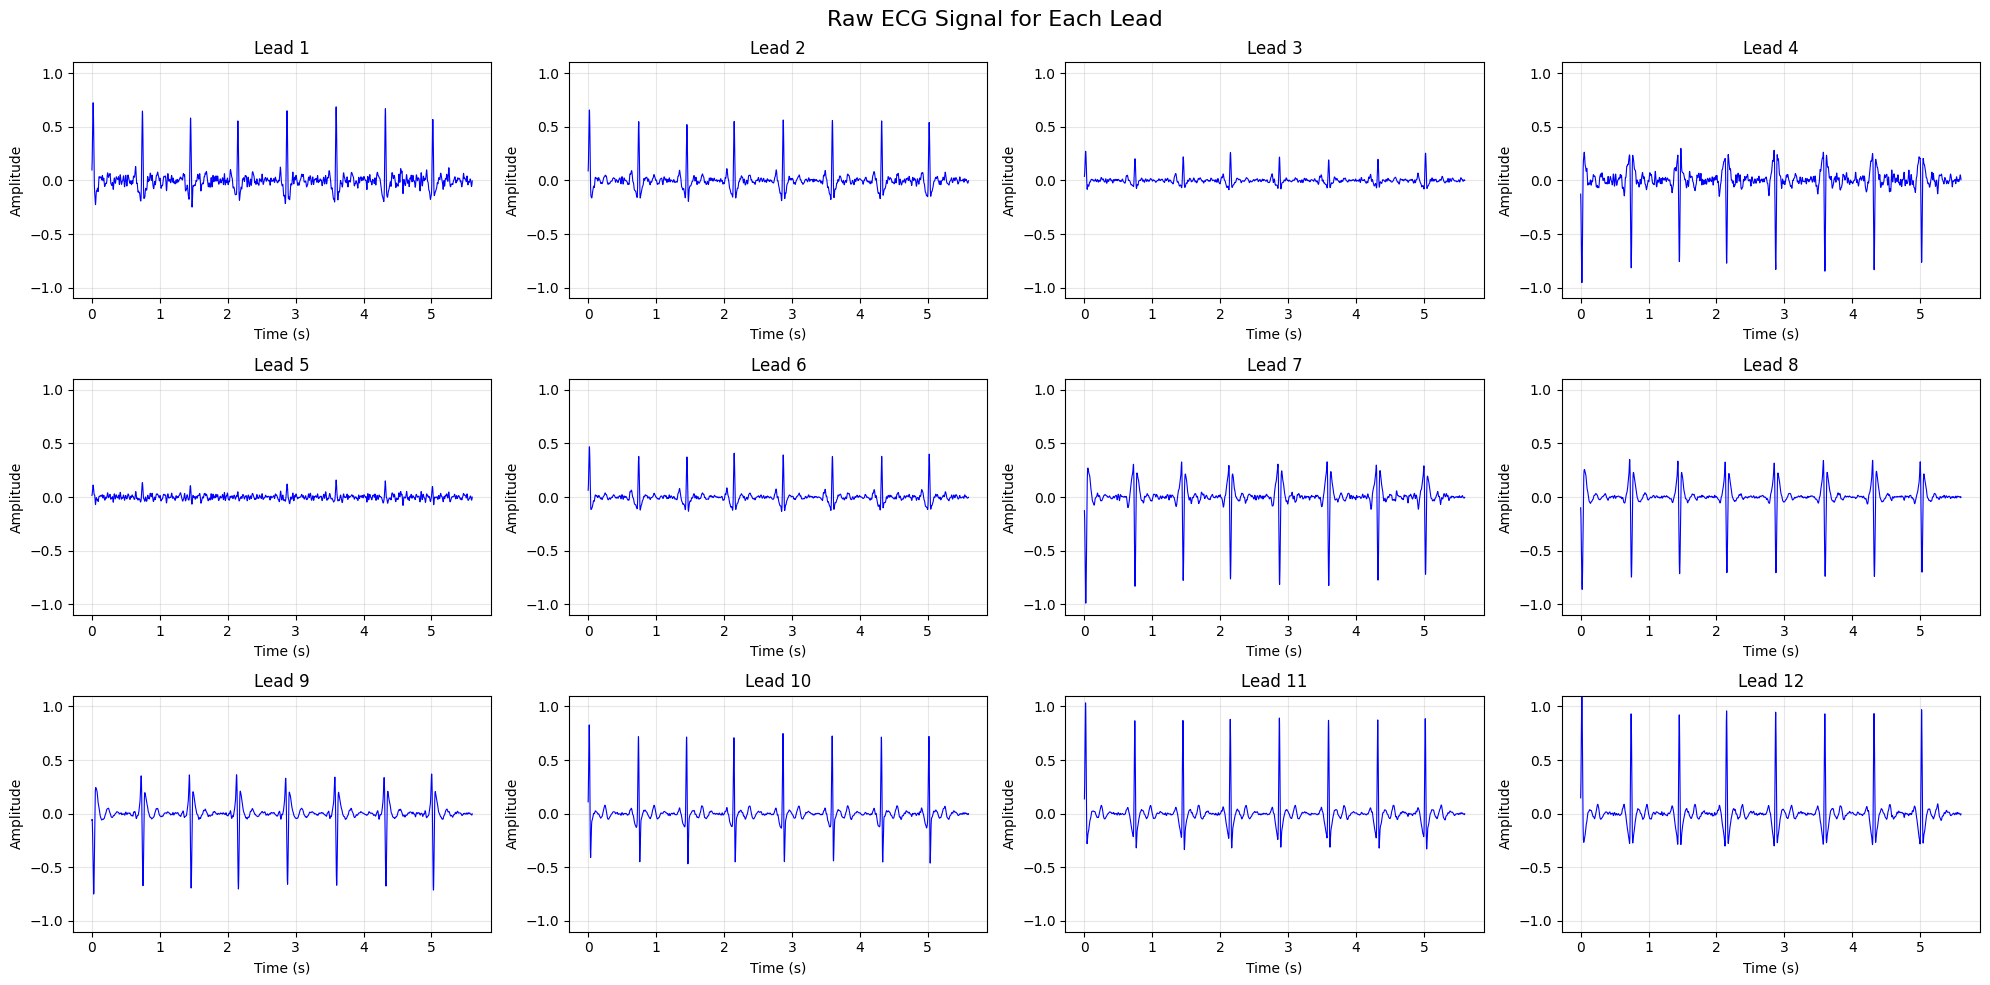

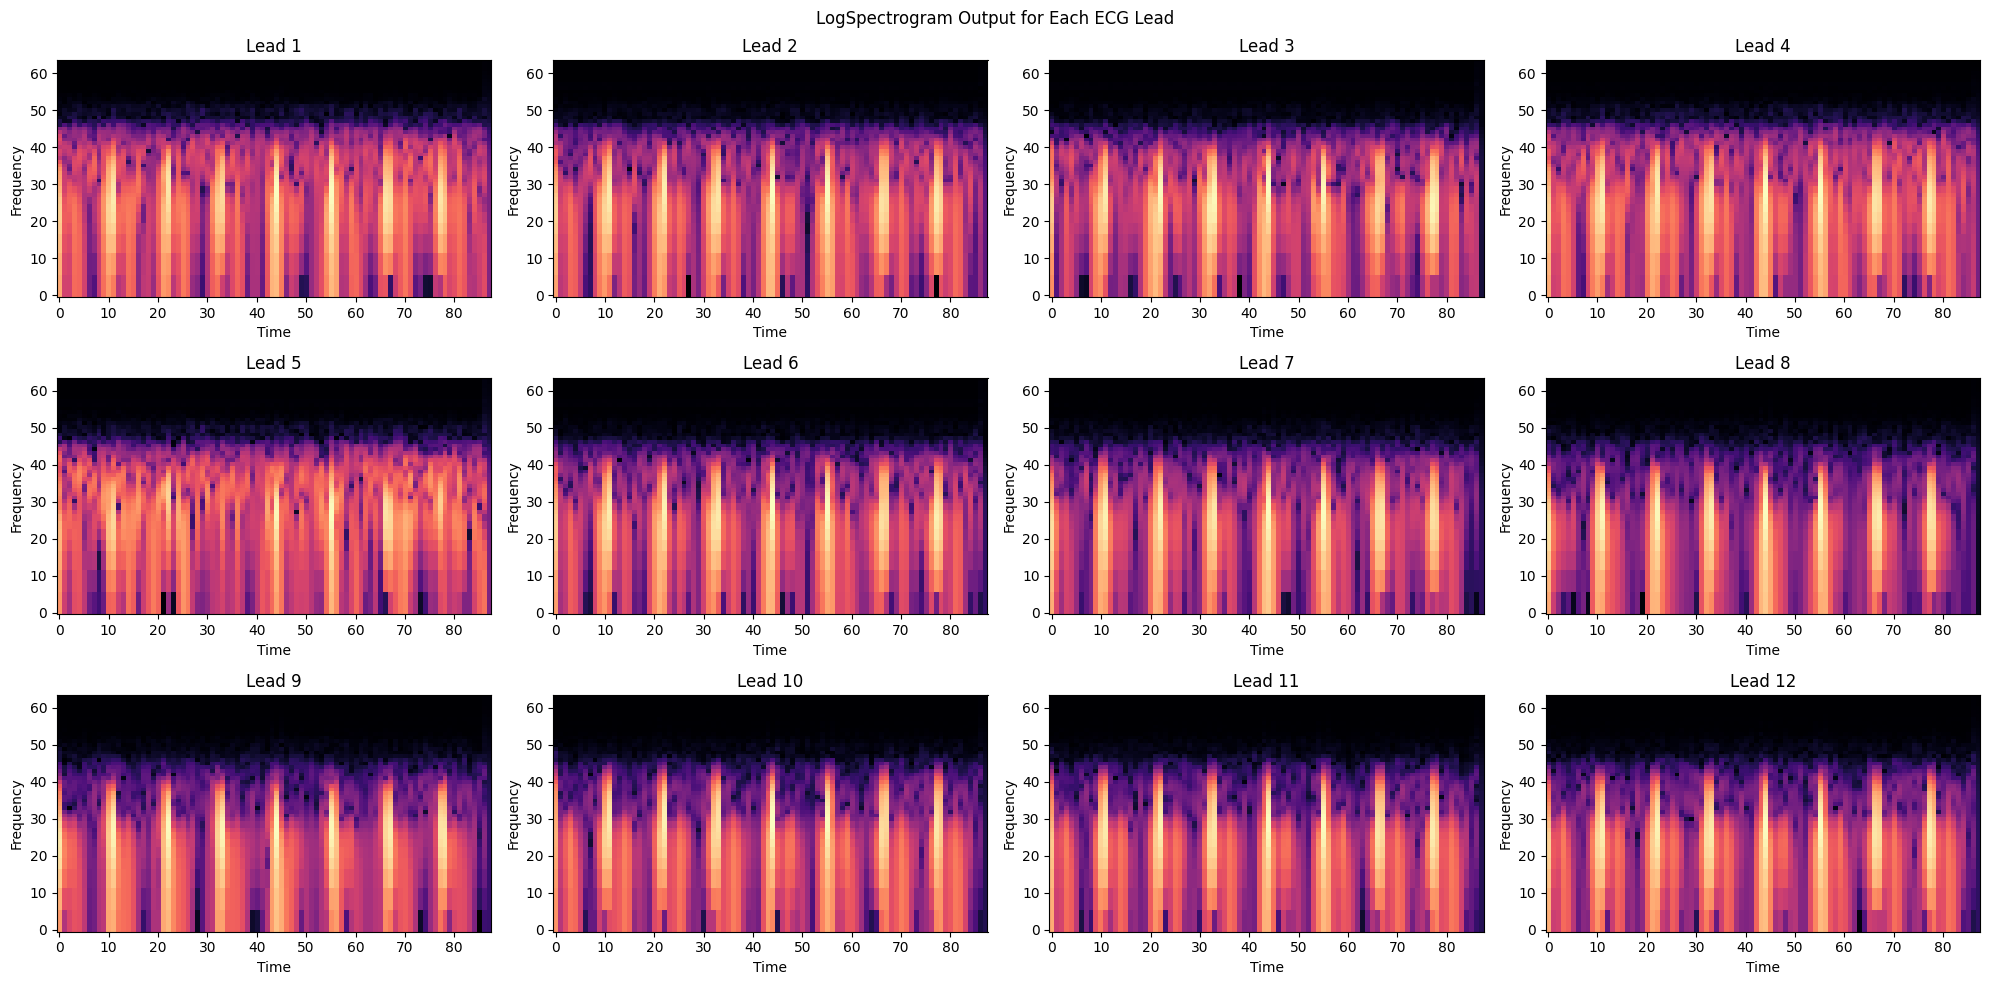

In [ ]:
preprocessed_example = FiltfiltNoiseReducer(fs=400, iir_freq=60.0, butterworth_cutoff=5., lowpass_cutoff=60., verbose=True)([raw_sample])[0]

show_raw_ecg_from_sample(preprocessed_example)
show_spectrogram_from_sample(naive_model((2800, 12)), preprocessed_example)


In [5]:
from preprocessing.filters import FiltfiltNoiseReducer

filter = FiltfiltNoiseReducer(fs=400, iir_freq=60.0, butterworth_cutoff=5., lowpass_cutoff=60., verbose=True)

X_train = filter(X_train)
X_val = filter(X_val)
X_test = filter(X_test)


Filtering records - filtfilt: 100%|██████████| 2245/2245 [00:14<00:00, 152.08record/s]


## Modelli

Nel nostro percorso sperimentale abbiamo preso in esame alcune delle principali architetture impiegate nella classificazione di sequenze temporali, adattandole al contesto specifico dei segnali ECG, che si distinguono per la presenza di pattern geometrici ricorrenti. L’obiettivo era valutare come questi modelli si comportano di fronte a dati brevi, grezzi e multicanale, tipici della pratica clinica.

Per confrontare le diverse soluzioni, abbiamo scelto di monitorare due metriche chiave: l’**accuratezza**, che fornisce una misura diretta delle previsioni corrette, e l’**AUC** (Area Under the Curve), particolarmente rilevante in ambito clinico per la sua capacità di misurare la discriminazione tra classi.
Le reti sono state addestrate con l’ottimizzatore Adam, mentre la funzione di perdita adottata è la Binary Cross Entropy, standard per i problemi di classificazione binaria.

### GRU e LSTM

In una prima fase abbiamo testato due modelli essenziali, ciascuno composto esclusivamente da due layer ricorrenti bidirezionali: uno basato su LSTM, l’altro su GRU, entrambi seguiti da una semplice testa di classificazione.

- Il modello **LSTM** risulta incapace di trovare pattern per la classificazione in questo set di dati, mantenendo una *accuracy* di $0.50$, ovvero producendo output casuali.

- Il modello **GRU** si dimostra più stabile, raggiungendo valori in *accuracy* di $0.70$ e in *AUC* di $0.75$ sul set di validazione.


### Estensione con layer convolutivi

Per migliorare la capacità dei modelli ricorrenti di apprendere dai segnali ECG grezzi, abbiamo introdotto una fase preliminare di elaborazione mediante due blocchi di convoluzione 1D. Questa componente convolutiva consente al modello di estrarre automaticamente pattern locali ricorrenti — come picchi, onde e variazioni improvvise — che rappresentano elementi fondamentali per la diagnosi cardiaca, ma che spesso sfuggono ad una semplice elaborazione ricorrente.

- **Conv1D + LSTM**: la combinazione ha permesso di ottenere risultati solidi, con un'accuracy intorno a $0.70$ e un’AUC che ha raggiunto $0.78$, segnalando una maggiore capacità discriminativa rispetto alla versione senza convoluzioni.

- **Conv1D + GRU**: in questo caso l’accuracy si è mantenuta stabile attorno a $0.71$, ma si è osservato un ulteriore incremento dell’AUC fino a $0.79$, indicando una migliore sensibilità del modello nel distinguere tra classi positive e negative.


### Spettrogramma e Conv2D

Il lavoro [*Convolutional Recurrent Neural Networks for Electrocardiogram Classification*](https://ieeexplore.ieee.org/document/8331491) mostra come l’integrazione tra rappresentazioni spettrali e modelli ibridi basati su convoluzioni e reti ricorrenti possa migliorare sensibilmente la classificazione dei segnali ECG. Gli autori osservano, in particolare, che *i primi esperimenti hanno mostrato come la trasformazione logaritmica migliori in modo significativo l'accuratezza della classificazione*, evidenziando il valore di questa operazione nel pre-processing del segnale.

Seguendo questa indicazione, abbiamo implementato un layer personalizzato che trasforma le sequenze ECG in spettrogrammi logaritmici, focalizzandosi sulle bande di frequenza più rilevanti per questo tipo di segnali.

`LightLogSpectrogram` trasforma segnali ECG grezzi in una rappresentazione spettrale più compatta e informativa. Per ciascun canale (lead), il layer applica una Trasformata di Fourier a breve termine (STFT) su finestre temporali sovrapposte, restituendo un tensore complesso che rappresenta l’energia del segnale nelle varie frequenze nel tempo.

Successivamente, viene applicata una compressione dinamica tramite la funzione `log1p`, combinata con uno scaling costante (`scale=128.0`), per attenuare l’effetto dei picchi più intensi e migliorare la leggibilità dei pattern frequenziali. Per ridurre ulteriormente la dimensionalità e concentrarsi sulle frequenze clinicamente rilevanti, le componenti spettrali vengono poi raggruppate in modo non lineare su scala logaritmica, selezionando `num_log_bins` (ad esempio 64) bande di frequenza.

Questa trasformazione non solo migliora l’efficienza computazionale del modello, ma permette anche di evidenziare le strutture ritmiche più significative, facilitando l’apprendimento da parte dei modelli convolutivi.

Il codice seguente mostra un esempio di utilizzo del layer `LightLogSpectrogram` all'interno di un modello basato unicamente su convoluzioni. L'integrazione di questa rappresentazione spettrale ha portato a un incremento significativo delle performance, migliorando l’accuracy del modello anche senza l’impiego di componenti ricorrenti.


```python
def build_cnn_model(input_shape=(2800, 12)):
    inputs = tf.keras.Input(shape=input_shape)  # 12-lead ECG time series

    # Logarithmic spectrogram
    x = LightLogSpectrogram()(inputs)  # shape: [batch, time, freq, 12]

    # Simple Conv2D block
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_32")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_64')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary output

    return tf.keras.Model(inputs, outputs, name="small_cnn")
```

![image](https://github.com/dokunoale/chagas/blob/dev/notebooks/assets/simple_models_comparison.png?raw=1)

Come si può notare, si ha un significativo miglioramento in fase di training, poichè con quest'ultimo modello l'accuracy e l'AUC sul set di validazione raggiungono rispettivamente $0.74$ ($+4\%$) e $0.83$ ($+8\%$)

### Recurrent CNN con GRU

In questo modello vengono combinati approcci già esplorati in precedenti esperimenti, tra cui semplici CNN, GRU e la loro integrazione con convoluzioni 2D. Il modello risultante può essere suddiviso in due grandi blocchi:
- il **blocco convolutivo**, che ha il compito di estrarre caratteristiche spaziali dallo spettro dei segnali ECG

- il **blocco ricorrente**, che si occupa di modellare le dinamiche temporali alla base del segnale.

Per garantire il corretto passaggio tra la fase convolutiva e quella sequenziale, è stato introdotto un layer di pooling temporale personalizzato. Questo passaggio permette di ridurre la complessità mantenendo la coerenza temporale, preservando così le informazioni dinamiche essenziali per l’analisi dei segnali ECG.

```python
@tf.keras.utils.register_keras_serializable()
class TemporalMeanPooling(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=2)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[3])
```
Il layer `TemporalMeanPooling` calcola la media lungo la dimensione delle frequenze (asse 2) per ogni timestep della sequenza, producendo un tensore di forma compatibile con i layer ricorrenti. In questo modo, le informazioni spaziali vengono sintetizzate senza perdere la struttura sequenziale, rendendo possibile il passaggio alla modellazione temporale.

Il tensore risultante viene quindi elaborato da una prima **GRU** con 32 unità per direzione e `return_sequences=True`, che restituisce un output sequenziale di forma `(batch, time_steps, 32)`. Successivamente, un secondo strato GRU con `return_sequences=False` condensa l'intera sequenza in un singolo vettore di dimensione `(batch, 32)`, rappresentando in forma compatta l'informazione temporale accumulata.

Infine, questo vettore viene passato a un layer Dense con attivazione sigmoide per ottenere l'output finale, ovvero la probabilità di appartenenza alla classe positiva.

```python
def build_cnn_model(input_shape=(2800, 12)):
    inputs = tf.keras.Input(shape=input_shape)  # 12-lead ECG time series

    # Logarithmic spectrogram
    x = LightLogSpectrogram()(inputs)  # shape: [batch, time, freq, 12]

    # Simple Conv2D block
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_32")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_64')(x)
    x = TemporalMeanPooling(name="temporal_pooling")(x)

    # GRU con 64 canali in input
    x = tf.keras.layers.GRU(32, return_sequences=True, name='gru_32_sequence')(x)  # output: (None, 32)
    x = tf.keras.layers.GRU(32, return_sequences=False, name='gru_32')(x)  # [batch, 32]

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary output

    return tf.keras.Model(inputs, outputs, name="RCNN")
```

Abbiamo inoltre testato un modello con la stessa architettura ma inserendo la **Bidirectional GRU**, in modo tale da permettere alla rete di analizzare la sequenza temporale sia in avanti che all’indietro. Tuttavia, nonostante l’aumento teorico della capacità espressiva, i risultati sperimentali hanno mostrato che l’utilizzo della GRU semplice senza bidirezionalità garantiva prestazioni simili o leggermente migliori nel contesto specifico di questo task.

Come si può constatare dai grafici di training, infatti, tutti e tre questi ultimi modelli presentano delle prestazioni molto simili tra loro, se consideriamo il task di classificazione binaria:
![image](https://github.com/dokunoale/chagas/blob/dev/notebooks/assets/hybrid_models_comparison.png?raw=1)

Tuttavia, se ci concentriamo maggiormente sulla capacità del modello di fare una **predizione regressiva dell'indice di rischio**, notiamo come il blocco convolutivo da solo tenda a generare una distribuzione delle probabilità più piatta e meno polarizzata, con una maggiore incertezza nelle predizioni intermedie. Al contrario, l’aggiunta del blocco GRU, sia nella versione semplice che bidirezionale, permette al modello di sfruttare la componente temporale dei segnali ECG, migliorando la separazione tra i casi a basso e alto rischio.

![image](https://github.com/dokunoale/chagas/blob/dev/notebooks/assets/distribution_comparison.png?raw=1)

In particolare, si può notare che mentre le predizioni sui valori reali negativi rimangano lineari, quelle sulla classe positiva seguano una tendenza logaritmica. Questo si traduce in una recall più alta sui modelli ibridi rispetto al modello `Conv2D`. Un dato positivo considerando che nel mondo reale le due classi saranno fortemente sbilanciate.


In [8]:
conv2D = tf.keras.models.load_model('/content/chagas/keras/simple_cnn.keras')
convGRU = tf.keras.models.load_model('/content/chagas/keras/simple_rcnn.keras')
convBiGRU = tf.keras.models.load_model('/content/chagas/keras/bircnn_gru.keras')

from sklearn.metrics import recall_score

def evaluate_model(name, model, X_test, y_test, treshold):
    y_pred_prob = model.predict(X_test)
    y_pred_class = (y_pred_prob >= treshold).astype(int)
    print(f"{name} Recall:", round(recall_score(y_test, y_pred_class), 2), f"with treshold: {treshold}")

models = {
    "Conv2D": conv2D,
    "ConvGRU": convGRU,
    "ConvBiGRU": convBiGRU
}

for name, model in models.items():
    evaluate_model(name, model, X_test, y_test, .5)

71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
Conv2D Recall: 0.76 with treshold: 0.5
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
ConvGRU Recall: 0.84 with treshold: 0.5
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
ConvBiGRU Recall: 0.83 with treshold: 0.5


## Analisi dei risultati

Il netto miglioramento della recall nei modelli ibridi rispetto al semplice `Conv2D` rappresenta un risultato particolarmente rilevante, soprattutto in scenari con forte sbilanciamento tra le classi.

Nei paragrafi seguenti analizzeremo in dettaglio le prestazioni dell'architettura che ha ottenuto i risultati migliori risultando il miglior compromesso per il task di classificazione: **Conv2D + GRU**.


### Matrice di Confusione

![image](https://github.com/dokunoale/chagas/blob/dev/notebooks/assets/RCNN_Confusion_Matrix.png?raw=1)

Il modello mostra una buona capacità di distinguere correttamente sia i casi positivi che quelli negativi. Sebbene si rilevi un numero consistente di falsi positivi e falsi negativi, la loro distribuzione risulta relativamente equilibrata sul test set bilanciato, segno che il modello non è affetto da un bias marcato verso una delle due classi.

Nonostante la **recall elevata** porti fisiologicamente a un incremento dei falsi positivi, il comportamento del modello rimane bilanciato nel complesso, il che è un risultato incoraggiante. Questo equilibrio è tanto più rilevante se consideriamo che, nei dati reali, la distribuzione delle classi sarà fortemente sbilanciata, rendendo preferibile un modello che tenda a sovrastimare i positivi piuttosto che trascurarli.

Va inoltre notato che, come si vedrà più avanti, il modello ibrido (`Conv2D+GRU`) tende a classificare i casi positivi secondo una **scala logaritmica**, in netto contrasto con l’andamento lineare osservato nel modello puramente convolutivo. Nonostante ciò, riesce comunque a mantenere una matrice di confusione ben bilanciata, dimostrando una buona robustezza rispetto alla soglia decisionale adottata (nel caso specifico, \$0.59\$). Tale soglia potrebbe comunque essere ulteriormente ottimizzata in base allo scenario applicativo, ad esempio privilegiando la riduzione dei falsi negativi in contesti clinici o di screening preventivo.


### Distribuzioni

![image](https://github.com/dokunoale/chagas/blob/dev/notebooks/assets/predictions_1.PNG?raw=1)

- In alto - **Distribuzione delle predizioni**: mostra la distribuzione delle probabilità predette dal modello, evidenziando le classificazioni corrette (in blu) e quelle errate (in rosso). La linea tratteggiata verticale rappresenta la soglia di classificazione, in questo caso $0.59$, che può variare a seconda del criterio decisionale adottato.

- In basso - **Distribuzione delle classi in base all'output del modello**:
rappresenta come i punteggi prodotti dal modello (asse x) si distribuiscono nei vari sottogruppi definiti dall’origine dei dati e dalla classe reale. Questo permette di valutare come i diversi segmenti del dataset vengono classificati e di identificare eventuali squilibri. I gruppi includono:
    - Casi negativi per Chagas provenienti da CODE-15% (azzurro chiaro)
    - Casi positivi per Chagas provenienti da CODE-15% (azzurro scuro)
    - Casi positivi per Chagas provenienti da SaMi-Trop (giallo)

Dall'analisi della distribuzione delle predizioni si osserva una **forte polarizzazione** delle classificazioni positive, con una netta prevalenza di predizioni corrette (in blu) concentrate nelle fasce estreme. Questo suggerisce che il modello ha una buona capacità di distinguere tra i due gruppi nei casi più chiari di positività, mentre tende a commettere errori (in rosso) prevalentemente nelle zone intermedie, dove le probabilità sono più incerte e vicine alla soglia di decisione.

Nel secondo grafico, che mostra la distribuzione dei gruppi in base all’output del modello, si osserva un comportamento coerente e incoraggiante su entrambi i dataset considerati. I casi positivi del dataset **SaMi-Trop** (giallo) tendono a concentrarsi nettamente oltre la soglia decisionale. Anche i casi positivi del dataset **CODE-15%** (azzurro scuro) mostrano una tendenza verso valori di output elevati, sebbene in modo meno marcato rispetto a SaMi-Trop. Questo rimane comunque un risultato positivo: se da un lato è possibile che il modello stia catturando alcune caratteristiche intrinseche specifiche di uno dei due dataset, la distribuzione delle etichette predette riflette nel complesso quella dei dataset di origine. Ciò suggerisce una **buona capacità di generalizzazione**, anche in presenza di dati meno espliciti o potenzialmente più rumorosi.

Nel complesso, questo comportamento riflette uno degli **obiettivi principali dell’esperimento**: verificare la capacità del modello di operare in modo affidabile su dataset diversi, come condizione necessaria per una futura applicazione in scenari reali.

###Elementi di Equità algoritmica
Per investigare la relazione tra l’età dei pazienti e le prestazioni del modello, sono stati analizzati i risultati delle predizioni in termini di accuratezza e distribuzione dell’output del classificatore binario, stratificati per gruppi di età decennali. I dati sono stati aggregati in tre visualizzazioni distinte, che consentono di osservare l’efficacia predittiva del modello rispetto alla variabilità demografica:

![image](https://github.com/dokunoale/chagas/blob/dev/notebooks/assets/predictions_age.PNG?raw=1)

Nel primo pannello, **“Age Distribution – Correct Predictions”**, viene riportata la distribuzione dell’output del modello per i soli casi classificati correttamente. Le predizioni corrette si distribuiscono lungo tutte le fasce d’età, con una maggiore concentrazione nei gruppi compresi tra i 30 e i 79 anni, coerente con la composizione del dataset.

Il secondo pannello, **“Age Distribution – Incorrect Predictions”**, mostra la distribuzione dell’output del modello limitatamente ai casi errati. Le età coinvolte negli errori sono anch’esse distribuite in maniera ampia, ma si osserva una maggiore presenza dei gruppi anagrafici più anziani, suggerendo una potenziale fragilità del modello in questi sottogruppi.

Infine, il terzo pannello, **“Prediction Success Rate by Age”**, presenta il tasso di accuratezza per ciascun intervallo di età. I risultati mostrano una performance elevata nelle fasce giovanili (fino a 27 anni), con percentuali di correttezza superiori all’85%, seguite da un declino progressivo dell’accuratezza con l’aumentare dell’età. Il minimo viene raggiunto nella fascia 77–87 anni, dove la percentuale di predizioni corrette si attesta attorno al 70%. Le etichette sovrastanti ciascuna barra indicano il numero di campioni presenti in ciascun gruppo, confermando che la ridotta accuratezza nei gruppi più anziani non è esclusivamente imputabile alla scarsità di dati, ma probabilmente riflette una maggiore eterogeneità dei segnali ECG dovuta all’età e alla presenza di patologie complesse.

## Conclusioni e possibili sviluppi futuri

### Conclusioni
Il progetto ha dimostrato la **fattibilità** dell'utilizzo di tecniche di Deep Learning per la rilevazione della malattia di Chagas mediante analisi automatizzata di elettrocardiogrammi. I risultati ottenuti evidenziano come un approccio che combina rappresentazioni spettrali e architetture neurali ibride possa raggiungere prestazioni clinicamente significative.

L'integrazione del layer `LightLogSpectrogram` si è rivelata particolarmente efficace, permettendo al modello di catturare pattern frequenziali clinicamente rilevanti che sfuggirebbero a una semplice analisi temporale.

L'analisi dei risultati ha rivelato una buona capacità del modello di identificare correttamente i casi più evidenti di Chagas, con una distribuzione delle predizioni fortemente polarizzata verso gli estremi. Tuttavia, la presenza di numerosi falsi negativi nel test set sottolinea la necessità di ulteriori ottimizzazioni per ridurre il rischio di mancata identificazione di pazienti affetti dalla patologia.

Un aspetto critico emerso dall'analisi è la variabilità delle prestazioni in funzione dell'età dei pazienti. Il modello mostra un'accuratezza superiore all'$85\%$ nelle fasce giovanili, ma registra un declino progressivo con l'aumentare dell'età, raggiungendo il $70\%$ nella fascia 77-87 anni. Questo fenomeno riflette probabilmente la maggiore complessità dei segnali ECG in pazienti anziani, caratterizzati da patologie multiple e alterazioni fisiologiche legate all'invecchiamento.


###Sviluppi Futuri
Per migliorare ulteriormente il modello sviluppato e garantirne l'affidabilità in contesti reali, saranno necessari diversi interventi strategici:

- **Passi Chiave per l'Affidabilità in Contesti Reali**:
Per rendere il modello affidabile e applicabile nella pratica clinica quotidiana, sarà indispensabile:
    - ampliare e migliorare la **qualità del dataset**, riducendo l’impatto di etichette deboli e rumore
    - integrare **dati clinici aggiuntivi** per aumentare la precisione diagnostica;


- **Miglioramento delle Performance**: si prevede l'esplorazione di architetture più sofisticate, come i Transformer adattati ai segnali biomedici o modelli di attenzione multi-scala, capaci di catturare pattern su diverse risoluzioni temporali. L’introduzione di strategie di data augmentation specifiche per segnali ECG, come rotazioni temporali o simulazione di artefatti clinici, potrà migliorare la capacità di generalizzazione, in particolare per i sottogruppi meno rappresentati.

- **Equità e Robustezza**: per garantire prestazioni eque tra i diversi gruppi demografici, sarà fondamentale mitigare il bias legato all’età, magari attraverso modelli specifici per fasce di età.

- **Implementazione Clinica**: per la reale integrazione del modello nei contesti ospedalieri, è necessario sviluppare interfacce user-friendly e sistemi di supporto decisionale che combinino le predizioni del modello con dati clinici aggiuntivi. Saranno fondamentali studi clinici prospettici per valutare l’impatto diagnostico e il rapporto costo-beneficio rispetto alle metodiche tradizionali.

- **Estensione del Dominio**: l'architettura proposta potrà essere riadattata per la diagnosi di altre patologie cardiache e potrà essere estesa al monitoraggio dei pazienti per identificare precocemente eventuali progressioni della malattia.

Solo attraverso questi passaggi sarà possibile sviluppare uno strumento robusto, sicuro ed efficace per supportare i medici nella diagnosi precoce della malattia di Chagas.